# Predict active users based on first 5 days

For this project I will attempt to do two things with a user's first five days of activity data on the app:
1. predict if they will use a activation code (ie do more than just browse for free)
2. predict the number of activation codes a user will use over the lifetime of this data set

I intend to give a detailed walk through of my rationale and approach at the presentation.

### Outline of approach

The first steps I took were to build up the data set that I will use to train a neural network. The basis of this data set is the user_info table. The code activations table is used to determine who has used a code and how many codes each user has used (the two target variables for the two tasks).

I used the questions sheet to get statistics on the question feature activity of each user in the first 5 days of use. The statistics derived are:
- number of questions answered
- percent of questions answered correctly
- time spent on questions
- number of distinct days the user used the questions feature (i.e. did they just do the questions on 1 day of the 5 or did they use it for all 5 etc.)

These statistics are at the user level, so I could then join them back to the user_info table

A similar aproach was also taken for the chapters read data. The following statistics were compiled for each user on the user's first 5 days of use:
- number of chapters read
- number of distinct days the user read at least one chapter

Again these are at a user level and were joined to the user_info table.

The various other categorical fields in the user_info table (signup device, marketing source etc) are were encoded so that they could be used appropriately in the model.

The data is then split into training and testing sets.

Neural networks were then defined: one for categorising whether or not a user would use and activation code and one for predicting the number of codes that would be used (regression). The models are trained on the training sets and validated onthe validation sets. 

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.utils import to_categorical

import livelossplot

Using TensorFlow backend.


#### Read data files

In [2]:
user_info = pd.read_csv('assessment_data/user_info.csv')
code_activations = pd.read_csv('assessment_data/code_activations.csv')
chapters_read = pd.read_csv('assessment_data/chapters_read.csv')
questions_read = pd.read_csv('assessment_data/questions_read.csv')

#### Determine what users have used an activation code

These will be our active users/users who have paid/redeem promotion code. They have actively engagend with the service.

In [3]:
min_act_date = code_activations.groupby(by='user_id', as_index=False).min()
user_info = pd.merge(user_info, min_act_date, on = 'user_id', how='left')
#user_info['diff_register_activate'] = (pd.to_datetime(user_info['code_activation']) - pd.to_datetime(user_info['register_date'])).dt.days
user_info['active'] = np.where(pd.isnull(user_info['code_activation']), 0, 1)

#### Find the number of codes used by each active user

In [4]:
num_codes = code_activations.groupby(by='user_id', as_index=False).count()
num_codes.rename(columns={'code_activation':'num_code_activations'}, inplace=True)

#### Convert categorical variables to one-hot-encoded variables

In [5]:
user_info = pd.get_dummies(user_info, prefix='country', columns=['country_id'])
user_info = pd.get_dummies(user_info, prefix='exam', columns=['next_exam_type'])
user_info = pd.get_dummies(user_info, prefix='marketing', columns=['marketing_source'])
user_info = pd.get_dummies(user_info, prefix='device', columns=['signup_device'])
user_info = pd.get_dummies(user_info, prefix='os', columns=['signup_os'])

#### Get first 5 days of question activity for each user
- number of questions answered
- time spent on qustions
- percent of questions answered correctly
- number of days active in the 5 day period

In [6]:
questions_read = pd.merge( questions_read, user_info[['user_id','register_date']], on = 'user_id', how='left')

questions_read['diff_register_questread'] = (pd.to_datetime(questions_read['created_at']) - 
                                             pd.to_datetime(questions_read['register_date'])).dt.days

qs_ans_fivedays = questions_read[questions_read['diff_register_questread']<5][['user_id','was_answer_correct']].groupby(by='user_id',
                                                                                        as_index=False).count()
qs_ans_fivedays.rename(columns={'was_answer_correct':'num_questions'}, inplace=True)

In [7]:
time_on_qs = questions_read[questions_read['diff_register_questread']<5][['user_id','time_spent']].groupby(by='user_id',
                                                                                        as_index=False).sum()

In [8]:
perct_right = questions_read[questions_read['diff_register_questread']<5][['user_id','was_answer_correct']].groupby(by='user_id',
                                                                                        as_index=False).mean()
perct_right.rename(columns={'was_answer_correct':'perct_right'}, inplace=True)

In [9]:
days_active = questions_read[questions_read['diff_register_questread']<5][['user_id','created_at']]
days_active['created_at'] = pd.to_datetime(days_active['created_at']).dt.date
days_active.drop_duplicates(inplace=True)
days_active = days_active.groupby(by='user_id',as_index=False).count()
days_active.rename(columns={'created_at':'days_answering'}, inplace=True)

#### Get first 5 days of chapter activity

- number of chapters read
- number of days active in the 5 day period

In [10]:
chapters_read = pd.merge(chapters_read, user_info[['user_id','register_date']], on = 'user_id', how='left')

chapters_read['diff_register_read'] = (pd.to_datetime(chapters_read['created_at']) - 
                                       pd.to_datetime(chapters_read['register_date'])).dt.days

chaps_read_fivedays = chapters_read[chapters_read['diff_register_read']<5][['user_id','chapter_id']].groupby(by='user_id',
                                                                                        as_index=False).count()
chaps_read_fivedays.rename(columns={'chapter_id':'num_chapters'}, inplace=True)

In [11]:
days_active1 = chapters_read[chapters_read['diff_register_read']<5][['user_id','created_at']]
days_active1['created_at'] = pd.to_datetime(days_active1['created_at']).dt.date
days_active1.drop_duplicates(inplace=True)
days_active1 = days_active1.groupby(by='user_id',as_index=False).count()
days_active1.rename(columns={'created_at':'days_reading'}, inplace=True)

#### Join this back to the user table

In [12]:
user_info = pd.merge(user_info, qs_ans_fivedays, on = 'user_id', how='left')
user_info = pd.merge(user_info, time_on_qs, on = 'user_id', how='left')
user_info = pd.merge(user_info, perct_right, on = 'user_id', how='left')
user_info = pd.merge(user_info, chaps_read_fivedays, on = 'user_id', how='left')
user_info = pd.merge(user_info, days_active, on = 'user_id', how='left')
user_info = pd.merge(user_info, days_active1, on = 'user_id', how='left')
user_info = pd.merge(user_info, num_codes, on = 'user_id', how='left')


user_info['num_questions'] = np.where(pd.isnull(user_info['num_questions']), 0, user_info['num_questions'])
user_info['time_spent'] = np.where(pd.isnull(user_info['time_spent']), 0, user_info['time_spent'])
user_info['perct_right'] = np.where(pd.isnull(user_info['perct_right']), 0, user_info['perct_right'])
user_info['num_chapters'] = np.where(pd.isnull(user_info['num_chapters']), 0, user_info['num_chapters'])
user_info['days_answering'] = np.where(pd.isnull(user_info['days_answering']), 0, user_info['days_answering'])
user_info['days_reading'] = np.where(pd.isnull(user_info['days_reading']), 0, user_info['days_reading'])
user_info['num_code_activations'] = np.where(pd.isnull(user_info['num_code_activations']), 0, user_info['num_code_activations'])

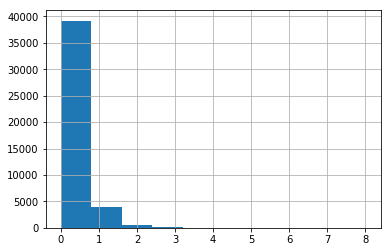

In [13]:
user_info['num_code_activations'].hist(bins=10)

In [14]:
user_info['num_code_activations'].describe(percentiles=[0.89,0.9,0.97,0.99])

count    43783.000000
mean         0.125802
std          0.402674
min          0.000000
50%          0.000000
89%          0.000000
90%          1.000000
97%          1.000000
99%          2.000000
max          8.000000
Name: num_code_activations, dtype: float64

In [15]:
user_info['active'].mean()

0.10501792933330288

#### Drop columns that won't be used in the classification model

In [16]:
active_user_classification = user_info.drop(columns=['register_date','user_id','code_activation','num_code_activations'],
                                            axis=1)

#### Split into test and train data for classification model

In [17]:
train, test = train_test_split(active_user_classification, test_size=0.2, shuffle=True)

X_train = train.drop(columns=['active'],axis=1)
y_train = train['active']

X_test = test.drop(columns=['active'],axis=1)
y_test = test['active']

X_train = X_train.values
y_train = to_categorical(y_train)

X_test = X_test.values
y_test = to_categorical(y_test)

#### Define neural network for classifying active users

In [18]:
def baseline_model():
    model = Sequential()
    model.add(Dense(259,input_dim=259,activation='relu'))
    model.add(Dense(1000,activation='tanh'))
    #model.add(Dropout(0.05))
    #model.add(Dense(100,activation='relu'))
    #model.add(Dense(10,activation='relu'))
    model.add(Dense(2,activation='softmax'))
    rmsprop = optimizers.RMSprop(lr=0.00005)
    model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
    return model

net_model = baseline_model()

#call plotting library so we can plot accuracy and loss
plot_losses = livelossplot.PlotLossesKeras()

#### Fit model and evaluate

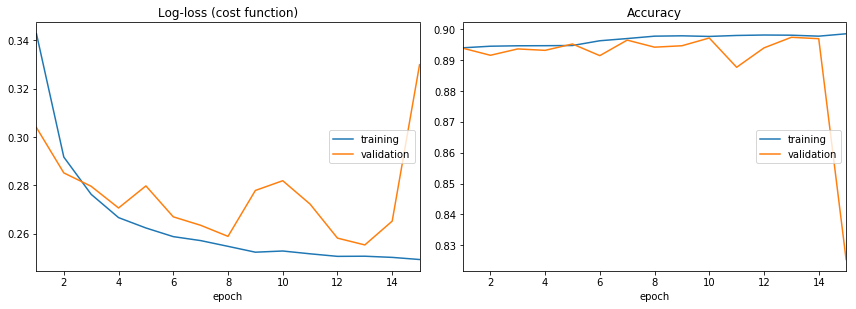

In [19]:
net_model.fit(X_train, y_train, epochs=15,
              batch_size=100, class_weight='balanced',
              callbacks=[plot_losses],
              validation_data=(X_test, y_test)
             )

#### Drop columns to get the data set to be used to the number of code activations a user will use

In [20]:
num_codes_pred_data = user_info.drop(columns=['register_date','user_id','code_activation','active'],
                                            axis=1)

#### Split into test and train sets for this regression problem

In [21]:
train1, test1 = train_test_split(num_codes_pred_data, test_size=0.2, shuffle=True)

X_train1 = train1.drop(columns=['num_code_activations'],axis=1)
y_train1 = train1['num_code_activations']

X_test1 = test1.drop(columns=['num_code_activations'],axis=1)
y_test1 = test1['num_code_activations']

X_train1 = X_train1.values

X_test1 = X_test1.values

#### Define neural network for regression problem

In [22]:
def baseline_model1():
    model = Sequential()
    model.add(Dense(259,input_dim=259,activation='relu'))
    #model.add(Dense(1000,activation='tanh'))
    #model.add(Dropout(0.1))
    model.add(Dense(100,activation='relu'))
    #model.add(Dense(10,activation='relu'))
    model.add(Dense(1,activation='relu'))
    adam = optimizers.Adam(lr=0.00001)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    return model

net_model = baseline_model1()

#### Fit and evaluate model

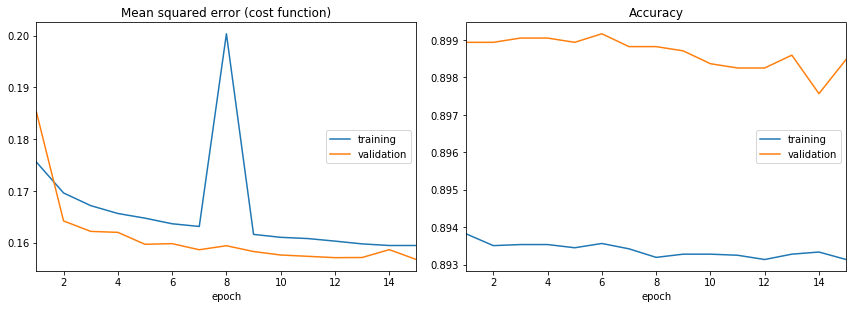

In [23]:
net_model.fit(X_train1, y_train1, epochs=15,
              batch_size=100,
              callbacks=[plot_losses],
              validation_data=(X_test1, y_test1)
             )

### Results

Unfortunately the results are inconclusive. 89% of the users are inactive, so guessing inactive on all the test set will mean that you are right 89% of the time to classify users. Likewise guessing 0 activation codes used will mean your right 89% too. So we want the model to improve on this accuracy. From the above we can see only a very minor improvement.

### Steps for improvement

The steps I would take to try improve the model:

- colloborate with key players (e.g. sales/marketing, subject matter experts, product partners etc.). This is vital for me, these are the people who know the product and how users interact with it best. A conversation with someone in the know makes for much faster progress and feedback cycles.

- Based on above feedback reconsider approach and rebuild/improve where necessary.

- Oversample data from the set of active users and use this to train the model. Currently we are working with a 10-90 split of active to inactive users. This combined with the fact that we are only considering 5 days of use data means that we have a relatively small set to work with. Oversampling will amplify characteristics of the active users and hopefully lead to better results.

- Utilise the time spent reading chapters data. This is useful information but needs to be used correctly. As it is only populated for mobile devices, nearly half the values are NULL. It is important to handle these NULLs appropriately. There are a few possibilities:
  1. set them to 0. Probably not a good option as it assumes no interaction
  2. fill them with the user's average time reading other chapters (if the information exists)
  3. fill them with the average time that chapter has been read (if the information exists)
  4. assign a random time from the distribution of observed times (probably the best option I think)
  
- One-hot-encode the chapters read column and use that as a predictor (I tried this but since there are over 2,000 chapters the additional columns significantly slowed my poor computer so I ended up not using it! :( )

- Define testing methodologies and implement a logging system to track performance of recommendations. Give constant feedback to stakeholders.

#### Notes on choice of tools

- I chose jupyter notebooks for this challenge because I think it is very good for doing quick analysis with unfamiliar data as it lets you see results immediatley and allows for things to be moved around and changed easily. It is also very useful and looks well for presenting and sharing code in an approachable way with with how you can embed well formatted comments.

- I chose Keras for a few reasons. As it is a wrapper around tensor flow it gives all the power of tf while being easy to use and read (which I think is important when sharing code).